In [245]:
from plotly.subplots import make_subplots
from sksurv.nonparametric import kaplan_meier_estimator as kme
from sksurv.preprocessing import OneHotEncoder as ohe
from sksurv.linear_model import CoxPHSurvivalAnalysis as cox
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import praw
import os
import glob
import time
from tqdm import tqdm
from dotenv import load_dotenv
import datetime as dt
import numpy as np
import pandas as pd
from pymongo import MongoClient
%config Completer.use_jedi = False

os.chdir('/shared/jackie/resilient-communities')

load_dotenv()

reddit = praw.Reddit(
    client_id=os.environ.get('REDDIT_CLIENT_ID_2'),
    client_secret=os.environ.get('REDDIT_CLIENT_SECRET_2'),
    user_agent=os.environ.get('REDDIT_USER_AGENT_2'),
    username=os.environ.get('REDDIT_USERNAME_2'),
    password=os.environ.get('REDDIT_PASSWORD_2')
)

client = MongoClient('localhost', 27017)
all_comments = client.resilient.all
popular_snapshots = client.resilient.popular
ps_comments = client.pushshift_comments
ps_threads = client.pushshift_comments

sample_subreddits = [
    'facepalm',
    'VALORANT',
    'gtaonline',
    'hungary'
]

In [307]:
sample_subreddits = open('sample.txt', 'r').read().split()

# Get the total number of comments.

In [3]:
pd.DataFrame.from_dict({
    'Comments': all_comments.estimated_document_count(),
}, orient='index').rename(columns={0: 'N'}).style.format('{:,}')

,N
Comments,"474,000,000"


# Get r/popular thread features.

Aggregating the r/popular snapshots collected in the database to a data frame that lists individual threads and their respective snapshots.

In [15]:
def get_popular_threads(subreddits=None, n=None):

    pipeline = [
        {'$sort': {'retrieved_utc': 1}},  # So snapshots pushed are in order.
        {'$group': {
            '_id': '$id',
            'subreddit': {'$first': '$subreddit'},
            'created_utc': {'$first': '$created_utc'},
            'title': {'$first': '$title'},
            'domain': {'$first': '$domain'},
            'is_self': {'$first': '$is_self'},
            'author': {'$first': '$author'},
            'selftext': {'$first': '$selftext'},
            'is_video': {'$first': '$is_video'},
            'num_snapshots': {'$sum': 1},
            'max_utc': {'$max': '$retrieved_utc'},
            'min_utc': {'$min': '$retrieved_utc'},
            'max_rank': {'$max': '$rank'},
            'min_rank': {'$min': '$rank'},
            'mean_rank': {'$avg': '$rank'},
            'max_upvotes': {'$max': '$score'},
            'min_upvotes': {'$min': '$score'},
            'mean_upvotes': {'$avg': '$score'},
            'max_upvote_ratio': {'$max': '$upvote_ratio'},
            'min_upvote_ratio': {'$min': '$upvote_ratio'},
            'mean_upvote_ratio': {'$avg': '$upvote_ratio'},
            'snapshots': {'$push': {
                'retrieved_utc': '$retrieved_utc',
                'rank': '$rank',
                'score': '$score',
                'upvote_ratio': '$upvote_ratio',
                'num_comments': '$num_comments'
            }}
        }}
    ]

    if subreddits is not None:
        pipeline = [{'$match': {'subreddit': {'$in': subreddits}}}] + pipeline

    popular_threads = pd.DataFrame(
        popular_snapshots.aggregate(pipeline, allowDiskUse=True)
    ).rename(columns={'_id': 'id'}).set_index('id')
    
    if n is not None:
        popular_threads = popular_threads[:n]

    for column in ['created_utc', 'max_utc', 'min_utc']:
        new_column = column.split('_')[0] + '_datetime'

        popular_threads[new_column] = \
            pd.to_datetime(popular_threads[column], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('US/Central')

    popular_threads['created_to_popular'] = popular_threads['min_utc'] - \
        popular_threads['created_utc']

    popular_threads['popular_window'] = popular_threads['max_utc'] - \
        popular_threads['min_utc']

    return popular_threads


popular_threads = get_popular_threads()
display(popular_threads)
display(popular_threads['subreddit'] \
            .value_counts() \
            .to_frame() \
            .rename(columns={'subreddit': 'Num. Popular'}))

,subreddit,created_utc,title,domain,is_self,author,selftext,is_video,num_snapshots,max_utc,...,mean_upvotes,max_upvote_ratio,min_upvote_ratio,mean_upvote_ratio,snapshots,created_datetime,max_datetime,min_datetime,created_to_popular,popular_window
id,,,,,,,,,,,,,,,,,,,,,
qqyi5z,copypasta,1.651465e+09,Predictions Tournament,reddit.com,False,Ragnar_OK,,False,184,1652557866,...,67126.402174,0.92,0.92,0.920000,"[{'retrieved_utc': 1651509021, 'rank': 45, 'sc...",2022-05-01 23:23:14-05:00,2022-05-14 14:51:06-05:00,2022-05-02 11:30:21-05:00,43627.0,1048845
qued9b,IndianDankMemes,1.648148e+09,Predictions Tournament,reddit.com,False,PharoahtheGod,,False,295,1653417793,...,23117.101695,0.99,0.95,0.965593,"[{'retrieved_utc': 1648191742, 'rank': 67, 'sc...",2022-03-24 13:45:38-05:00,2022-05-24 13:43:13-05:00,2022-03-25 02:02:22-05:00,44204.0,5226051
rw8i7w,HolUp,1.648715e+09,HOL'UPREDICTIONS: SEASON TWO,reddit.com,False,AsherFennec,,False,459,1653010991,...,122634.923747,0.93,0.91,0.916187,"[{'retrieved_utc': 1648759320, 'rank': 6, 'sco...",2022-03-31 03:26:37-05:00,2022-05-19 20:43:11-05:00,2022-03-31 15:42:00-05:00,44123.0,4251671
sbr44n,worldnewsvideo,1.648211e+09,r/Worldnewsvideo's User Prediction Contest for...,reddit.com,False,PlenitudeOpulence,,False,1160,1653973625,...,37606.293966,0.94,0.92,0.925612,"[{'retrieved_utc': 1648254922, 'rank': 33, 'sc...",2022-03-25 07:16:57-05:00,2022-05-31 00:07:05-05:00,2022-03-25 19:35:22-05:00,44305.0,5718703
t4btt4,wallstreetbets,1.648394e+09,🔮WallStreetBets Predictions Tournament for Mar...,reddit.com,False,ThetaGang_wsb,,False,57,1648444695,...,55849.894737,0.97,0.97,0.970000,"[{'retrieved_utc': 1648437841, 'rank': 39, 'sc...",2022-03-27 10:15:35-05:00,2022-03-28 00:18:15-05:00,2022-03-27 22:24:01-05:00,43706.0,6854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
v209r6,mildlyinfuriating,1.654032e+09,$100 worth of groceries,i.imgur.com,False,vinnie_the_poobah,,False,3,1654042389,...,3577.000000,0.82,0.82,0.820000,"[{'retrieved_utc': 1654042144, 'rank': 83, 'sc...",2022-05-31 16:12:30-05:00,2022-05-31 19:13:09-05:00,2022-05-31 19:09:04-05:00,10594.0,245
v20e8q,Damnthatsinteresting,1.654032e+09,"This man spoke with every parent in Uvalde, Te...",i.redd.it,False,jcepiano,,False,50,1654042389,...,27863.740000,0.98,0.94,0.957200,"[{'retrieved_utc': 1654036398, 'rank': 39, 'sc...",2022-05-31 16:18:02-05:00,2022-05-31 19:13:09-05:00,2022-05-31 17:33:18-05:00,4516.0,5991
v20npc,news,1.654033e+09,"Uvalde police, school district no longer coope...",abcnews.go.com,False,mateothegreek,,False,25,1654042389,...,17981.360000,0.98,0.98,0.980000,"[{'retrieved_utc': 1654039455, 'rank': 1, 'sco...",2022-05-31 16:30:13-05:00,2022-05-31 19:13:09-05:00,2022-05-31 18:24:15-05:00,6842.0,2934


,Num. Popular
memes,547
worldnews,494
MadeMeSmile,483
interestingasfuck,477
funny,453
...,...
Eve,1
self,1
velvethippos,1
JordanPeterson,1


# Get subreddit-level features from r/popular thread subreddits.

Collecting subreddit-level feautures, i.e., features that are attached to the subreddit. For example, the number of subscribers and moderators. Additional features include typical activity levels from posting, commenting, and moderator interventions.

- Doesn't include additional features describing the activity levels of the community, e.g., posting, commenting and moderator activity.

In [308]:
def get_subreddit_features(subreddits=None):
    
    if subreddits is None:
        subreddits = popular_threads['subreddit'].unique()
    
    assert popular_threads is not None, 'Get r/popular threads.'
    
    features = {}
    failed_subreddits = []
    
    for subreddit in subreddits:
        
        try:
            subreddit = reddit.subreddit(subreddit)

            features[subreddit.display_name] = {
                'num_moderators': len(list(subreddit.moderator())),
                'num_subscribers': subreddit.subscribers
            }
        except Exception:
            failed_subreddits.append(subreddit)
            
    print(f'Couldn\'t retrieved these subreddits: {failed_subreddits}')
        
    return pd.DataFrame.from_dict(features, orient='index') \
        .sort_values(by='num_subscribers', ascending=False)

subreddit_features = get_subreddit_features(sample_subreddits)
subreddit_features

Couldn't retrieved these subreddits: []


,num_moderators,num_subscribers
gaming,29,33012398
todayilearned,23,27744513
books,31,20945347
Art,23,20719132
space,29,20476045
...,...,...
FundieSnarkUncensored,13,104517
Coachella,13,91125
Foofighters,4,66166
fuslie,14,17552


# Get r/popular active window and number of comments from PRAW collection.

These features are generated from the live ingestion of Reddit comments from PRAW, hence PRAW features.

- It's too slow right now to collect features from all r/popular threads, so I need to just sample subreddit's r/popular threads instead.

In [309]:
def get_praw_features(subreddits=None):
    
    assert popular_threads is not None, 'Get r/popular threads.'
    
    if subreddits is None:
        selected_threads = popular_threads.index
    else:
        selected_threads = popular_threads[
            popular_threads['subreddit'].isin(subreddits)].index
    
    fullnames = 't3_' + selected_threads
    
    pipeline = [
        {'$project': {'_id': 1, 'link_id': 1, 'created_utc': 1, 'author': 1}},
        {'$match': {'link_id': {'$in': fullnames.tolist()}}},
        {'$group': {'_id': {'author': '$author', 'link_id': '$link_id'},
                    'first_utc': {'$min': '$created_utc'},
                    'last_utc': {'$max': '$created_utc'},
                    'num_comments': {'$sum': 1}}},
        {'$group': {'_id': '$_id.link_id',
                    'num_comments': {'$sum': '$num_comments'},
                    'first_utc': {'$min': '$first_utc'},
                    'last_utc': {'$max': '$last_utc'},
                    'num_authors': {'$sum': 1}}}
    ]
    
    praw_features = pd.DataFrame(
        all_comments.aggregate(
            pipeline, allowDiskUse=True
        )
    ).rename(columns={'_id': 'id'}).set_index('id')
    
    praw_features.index = praw_features.index.str[3:]
    
    praw_features['active_window'] = \
        praw_features['last_utc'] - praw_features['first_utc']
    
    return praw_features

praw_features = get_praw_features(subreddits=sample_subreddits)
praw_features

,num_comments,first_utc,last_utc,num_authors,active_window
id,,,,,
upy9aa,542,1.652589e+09,1.653026e+09,283,437318.0
utv68t,390,1.653052e+09,1.653311e+09,274,259018.0
uc1486,797,1.650937e+09,1.653975e+09,725,3038209.0
tnj7z8,117,1.648206e+09,1.648271e+09,105,65164.0
u9aeho,328,1.650619e+09,1.650907e+09,256,287641.0
...,...,...,...,...,...
u58jx8,4370,1.650147e+09,1.650456e+09,4171,308351.0
u6somm,1530,1.650330e+09,1.651714e+09,1068,1383979.0
u9rqx4,713,1.650670e+09,1.651819e+09,597,1149153.0


# Get the comments from each r/popular thread.

Pulling the individual comments from each r/popular thread captured in the live feed.

- Again, too slow. Most likely too many comments to retrieve from memory, so we're working with a sample of the r/popular threads.

In [21]:
def get_popular_comments(subreddits=None):

    assert popular_threads is not None, 'Get r/popular threads.'

    if subreddits is None:
        selected_threads = popular_threads.index
    else:
        selected_threads = popular_threads[
            popular_threads['subreddit'].isin(subreddits)].index
    
    fullnames = 't3_' + selected_threads

    popular_comments = pd.DataFrame(
        all_comments.aggregate([
            {'$project': {'id': 1, 
                          'link_id': 1, 
                          'created_utc': 1, 
                          'author': 1, 
                          'subreddit': 1}},
            {'$match': {'link_id': {'$in': fullnames.tolist()}}}
        ], allowDiskUse=True)
    ).set_index('id')
    
    popular_comments['link_id'] = popular_comments['link_id'].str[3:]
    
    popular_comments = popular_comments.drop(columns=['_id'])

    return popular_comments

popular_comments = get_popular_comments(subreddits=sample_subreddits)
popular_comments

,subreddit,author,link_id,created_utc
id,,,,
i1uygeb,facepalm,GadgetGod1906,tkv2c3,1.648076e+09
i1uykm4,facepalm,Hopeful_Wallaby3755,tkv2c3,1.648076e+09
i1uykn7,facepalm,Proof-Sweet33,tkv2c3,1.648076e+09
i1uymss,facepalm,Kthak_Back,tkv2c3,1.648076e+09
i1uynr2,facepalm,pessenshett,tkv2c3,1.648076e+09
...,...,...,...,...
iaq12gj,facepalm,labatomi,v1s727,1.654040e+09
iaq2w81,facepalm,ophaus,v1s727,1.654041e+09
iaq37jh,facepalm,AeroOnFire,v1s727,1.654041e+09


# Get re-query/removed comment features.

For a sample set of subreddits, we requery sufficiently old comments to see whether they've been removed and mark that in a separate data frame to be joined later. Sometimes the API is unable to retrieve certain comment IDs, don't have an idea what happened to them, might need to check them by hand to determine whether they've been removed or the API is being whacky.

- Expand the sample set of subreddits.

In [310]:
def get_requery_features(subreddits=None):

    if subreddits is not None:
        files = [f'removed/{subreddit}.pkl' for subreddit in subreddits]
    else:
        files = glob.glob('removed/*')
        subreddits = [file.split('/')[1][:-4] for file in files]

    comments = []

    for subreddit, file in zip(subreddits, files):
        _comments = pd.read_pickle(file)
        _comments['subreddit'] = subreddit
        comments.append(_comments)

    return pd.concat(comments, ignore_index=True).set_index('id')


requery_features = get_requery_features(subreddits=sample_subreddits)
requery_features

,retrieved_utc,removed,subreddit
id,,,
i1uygz0,1649303712,False,maybemaybemaybe
i1uyi8d,1649303712,False,maybemaybemaybe
i1uyiih,1649303712,False,maybemaybemaybe
i1uyjb3,1649303712,False,maybemaybemaybe
i1uymen,1649303712,False,maybemaybemaybe
...,...,...,...
iaeom2d,1654074896,False,MadeMeCry
iaeozx3,1654074896,False,MadeMeCry
iaep6ow,1654074896,False,MadeMeCry


# Get newcomer features, i.e., whether a comment was made by a newcomer.

This requires Pushshift data for each subreddit, all the way back to January 2020. For each subreddit, we find out each author's first comment, i.e., the comment where they're a newcomer.

- Add the thread the author was a newcomer in because a newcomer can comment multiple times in the same thread still making them a newcomer.

In [311]:
def get_newcomer_features(subreddits=None):
    
    frames = []
    
    for subreddit in subreddits:
        comments = pd.DataFrame(
            ps_comments[subreddit].aggregate([
                {'$group': {'_id': '$author',
                            'first_comment': {'$min': {
                                'created_utc': '$created_utc',
                                'author': '$author',
                                'id': '$id',
                                'permalink': '$permalink',
                                'subreddit': '$subreddit'
                            }}}},
                {'$replaceRoot': {'newRoot': '$first_comment'}},
                {'$match': {'created_utc': {'$gte': int(dt.datetime(2022, 3, 1).timestamp())}}}
            ], allowDiskUse=True)
        )
        
        frames.append(comments)
        
    return pd.concat(frames, ignore_index=True).set_index('id')
    
    
newcomer_features = get_newcomer_features(subreddits=sample_subreddits)
newcomer_features

,created_utc,author,permalink,subreddit
id,,,,
i1ut0li,1648073790,----------_______---,/r/maybemaybemaybe/comments/tl2e0p/maybe_maybe...,maybemaybemaybe
i3vt4vp,1649414367,------sb,/r/maybemaybemaybe/comments/tywplm/maybe_maybe...,maybemaybemaybe
i0cnyxu,1647076944,----Ant----,/r/maybemaybemaybe/comments/tbzcke/maybe_maybe...,maybemaybemaybe
i40vxoc,1649505444,---Kung_Fu_Genius---,/r/maybemaybemaybe/comments/tz906p/maybe_maybe...,maybemaybemaybe
i6zbosy,1651458146,--ASSFACE--,/r/maybemaybemaybe/comments/ug3gtq/maybe_maybe...,maybemaybemaybe
...,...,...,...,...
i08a7xa,1646999239,DocJagHanky,/r/MadeMeCry/comments/tbaoqn/i_feel_sorry_for_...,MadeMeCry
i3dx9h3,1649097986,OG_Rumination,/r/MadeMeCry/comments/tw2xdm/volodymyr_zelensk...,MadeMeCry
i63yux7,1650878985,Alternative-Donkey51,/r/MadeMeCry/comments/uazep7/this_guys_old_bes...,MadeMeCry


# Combine comment features.

Cell combining the comment features into a singular data frame.

In [312]:
def combine_comment_features():
    
    assert popular_comments is not None, 'Get r/popular comments.'
    assert requery_features is not None, 'Get requeried results.'
    assert newcomer_features is not None, 'Get newcomer results.'
    
    combined_comments = popular_comments.join(requery_features[['removed', 'retrieved_utc']])
    
    _newcomer_features = pd.DataFrame(index=newcomer_features.index)
    _newcomer_features['newcomer'] = True
    
    combined_comments = combined_comments.join(_newcomer_features)
    combined_comments['newcomer'] = combined_comments['newcomer'].fillna(False)
    
    return combined_comments
    
    
complete_comment_features = combine_comment_features()
complete_comment_features

,subreddit,author,link_id,created_utc,removed,retrieved_utc,newcomer
id,,,,,,,
i1uygeb,facepalm,GadgetGod1906,tkv2c3,1.648076e+09,False,1649309029,False
i1uykm4,facepalm,Hopeful_Wallaby3755,tkv2c3,1.648076e+09,False,1649309029,True
i1uykn7,facepalm,Proof-Sweet33,tkv2c3,1.648076e+09,False,1649309029,True
i1uymss,facepalm,Kthak_Back,tkv2c3,1.648076e+09,False,1649309029,False
i1uynr2,facepalm,pessenshett,tkv2c3,1.648076e+09,False,1649309029,True
...,...,...,...,...,...,...,...
iaq12gj,facepalm,labatomi,v1s727,1.654040e+09,NaN,NaN,False
iaq2w81,facepalm,ophaus,v1s727,1.654041e+09,NaN,NaN,False
iaq37jh,facepalm,AeroOnFire,v1s727,1.654041e+09,NaN,NaN,False


# Visualizations

Section containing multiple visualizations of the data above.

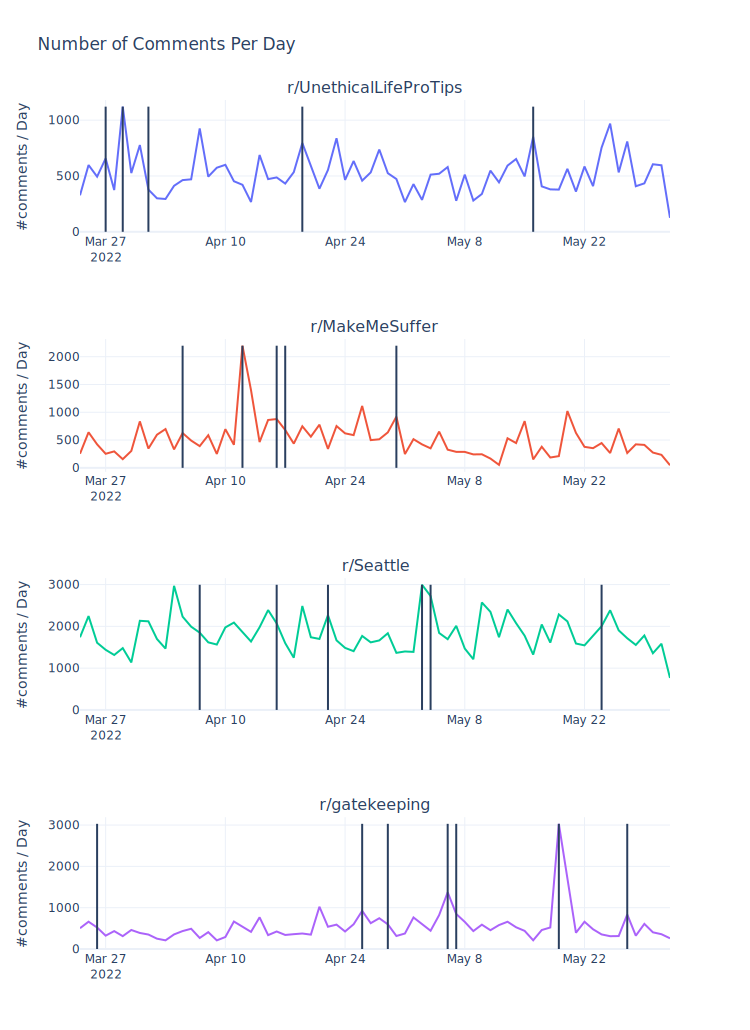

In [24]:
def get_subreddit_comments(subreddits):

    return pd.DataFrame(
        all_comments.aggregate([
            {'$match': {'subreddit': {'$in': subreddits}}},
            {'$project': {'subreddit': 1, 'created_utc': 1}}
        ])
    )


def get_popular_timestamps(subreddits):

    assert popular_threads is not None, 'Get r/popular threads.'

    mask = popular_threads['subreddit'].isin(subreddits)

    timestamps = popular_threads[mask][['subreddit', 'min_datetime']]

    return timestamps


def count_comments(comments, bin_size):
    count = pd.to_datetime(comments['created_utc'], unit='s') \
        .dt.tz_localize('UTC') \
        .dt.tz_convert('US/Central') \
        .round(bin_size) \
        .value_counts() \
        .sort_index()

    count = count.reindex(
        pd.date_range(count.index[0], count.index[-1], freq=bin_size)
    )

    return count


def display_subreddit_comments(subreddits, save=False, bin_size='H'):

    assert bin_size == 'H' or bin_size == 'D', 'bin_size should either be \'H\' or \'D\'.'

    comments = get_subreddit_comments(subreddits)

    popular_timestamps = get_popular_timestamps(subreddits)

    fig = make_subplots(
        rows=len(subreddits),
        subplot_titles=tuple([f'r/{subreddit}' for subreddit in subreddits])
    )

    for i, subreddit in enumerate(subreddits):
        subreddit_comments = comments[comments['subreddit'] == subreddit]

        mask = popular_timestamps['subreddit'] == subreddit
        subreddit_popular_timestamps = popular_timestamps[mask]['min_datetime'].round('D').unique()

        count = count_comments(subreddit_comments, bin_size)

        fig.add_trace(
            go.Scatter(
                x=count.index,
                y=count.values
            ), row=i+1, col=1
        )
        
        for timestamp in subreddit_popular_timestamps:
            fig.add_shape(
                type='line',
                x0=timestamp, x1=timestamp,
                y0=0, y1=count.max(),
                row=i+1, col=1
            )

    bin_size_string = 'Hour' if bin_size == 'H' else 'Day'

    fig.update_layout(
        template='plotly_white',
        showlegend=False,
        height=30+250*len(subreddits),
        width=750,
        title='Number of Comments Per ' + bin_size_string
    )

    for i in range(1, len(subreddits) + 1):
        fig.layout[f'yaxis{i}'].title = '#comments / ' + bin_size_string

    if save:
        fig.write_image('figs/subreddit_timeline.png', scale=3)

    fig.show('svg')


display_subreddit_comments(
    ['UnethicalLifeProTips', 'MakeMeSuffer', 'Seattle', 'gatekeeping'],
    save=True,
    bin_size='D'
)

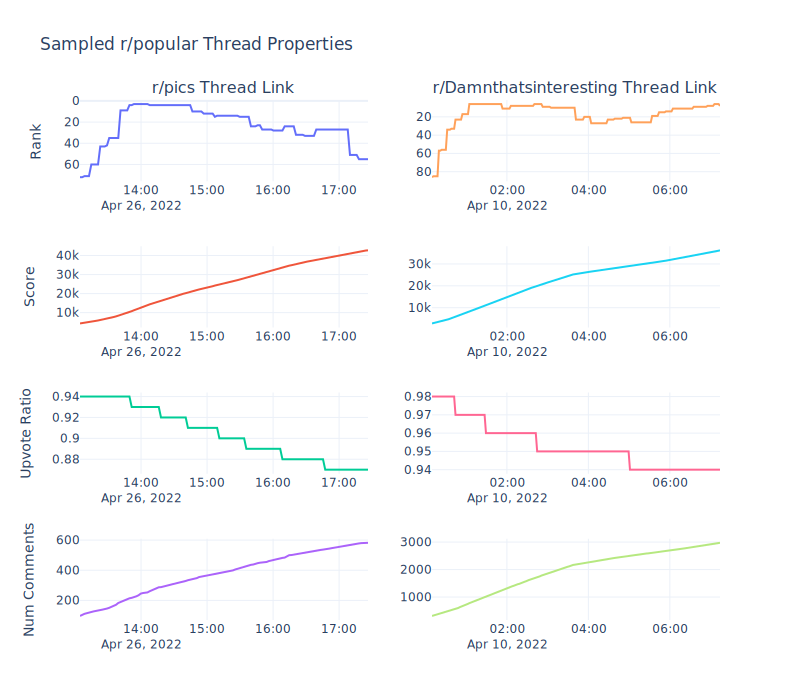

In [28]:
def display_popular_threads(save=False, n=2, seed=None):
    
    assert popular_threads is not None, 'Get r/popular threads.'
    
    sufficiently_old = popular_threads['created_utc'] \
        < int((dt.datetime.now() - dt.timedelta(days=5)).timestamp())
    
    if seed is None:
        sampled_threads = popular_threads[sufficiently_old].sample(n=n)
    else:
        sampled_threads = popular_threads[sufficiently_old].sample(n=n, random_state=seed)
    
    sampled_snapshots = [pd.DataFrame(snapshots) for snapshots in sampled_threads['snapshots']]

    titles = [
        f'<a href="https://reddit.com/{thread.Index}" target="_blank">r/{thread.subreddit} Thread Link</a>'
        for thread in sampled_threads.itertuples()
    ]
    
    fig = make_subplots(
        rows=4, cols=n,
        subplot_titles=tuple(titles) + tuple('' for _ in range(n * 3))
    )
    
    for col, snapshots in enumerate(sampled_snapshots):
        
        snapshots['datetime'] = pd.to_datetime(snapshots['retrieved_utc'], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('US/Central')
        
        for row, column in enumerate(['rank', 'score', 'upvote_ratio', 'num_comments']):
            fig.add_trace(
                go.Scatter(x=snapshots['datetime'], y=snapshots[column]),
                row=row+1, col=col+1
            )
            
            if column is 'rank':
                fig.update_yaxes(autorange='reversed', row=row+1, col=col+1)
            
            if col+1 == 1:
                fig.update_yaxes(title=column.replace('_', ' ').title(),
                                row=row+1, col=col+1)
            
        fig.update_layout(
            template='plotly_white',
            height=700,
            width=400*n,
            showlegend=False,
            title=f'Sampled r/popular Thread Properties'
        )
        
    if save:
        fig.write_image('figs/sampled_popular.png', scale=3)
            
    fig.show('svg')
    
display_popular_threads(save=True, seed=5)

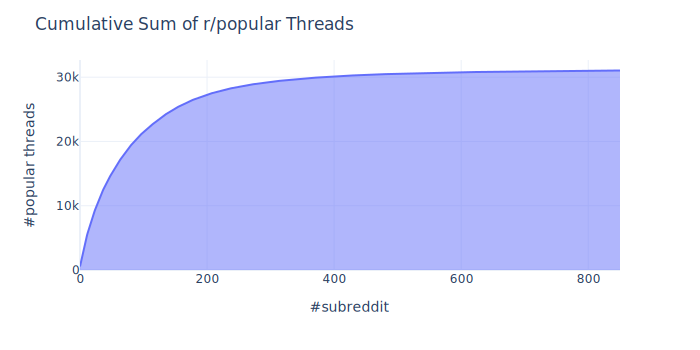

In [29]:
def display_cumulative_sum(save=False):
    
    assert popular_threads is not None, 'Get r/popular threads.'
    
    data = popular_threads['subreddit'] \
        .value_counts() \
        .cumsum() \
        .reset_index()['subreddit']
    
    fig = px.area(data)
    
    fig.update_layout(
        template='plotly_white',
        showlegend=False,
        xaxis_title='#subreddit',
        yaxis_title='#popular threads',
        title='Cumulative Sum of r/popular Threads',
        height=350,
    )
    
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)
    
    fig.show('svg')
    
    if save:
        fig.write_image('figs/cumulative_sum.png', scale=3)

display_cumulative_sum(save=True)

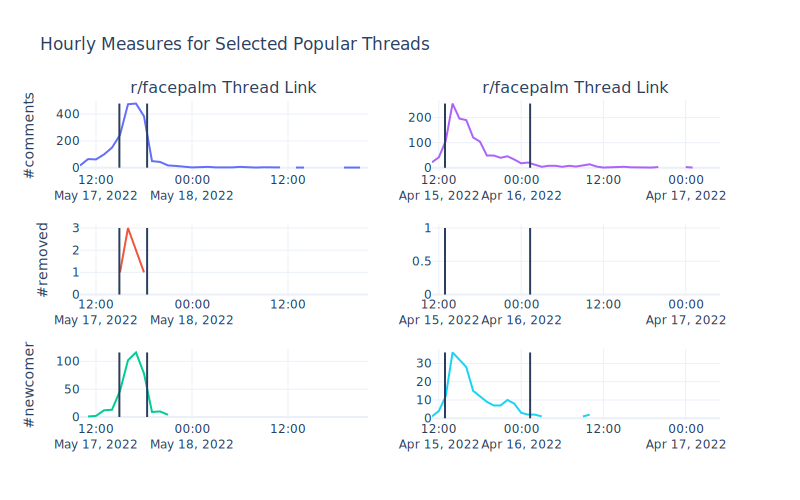

In [240]:
def display_comment_timeline(save=False, subreddits=None, seed=None):

    if subreddits is None:
        available_threads = popular_threads
    else:
        available_threads = popular_threads[
            popular_threads['subreddit'].isin(subreddits)]

    if seed is None:
        selected_threads = available_threads.sample(n=2)
    else:
        selected_threads = available_threads.sample(n=2, random_state=seed)

    fig = make_subplots(
        rows=3,
        cols=2,
        subplot_titles=tuple([
            f'<a href="https://reddit.com/{thread.Index}">r/{thread.subreddit} Thread Link</a>'
            for thread in selected_threads.itertuples()])
    )

    for col, thread in enumerate(selected_threads.itertuples()):
        
        # Counting comments.
        comments = complete_comment_features[
            complete_comment_features['link_id'] == thread.Index]

        comment_counts = pd.to_datetime(comments['created_utc'], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('US/Central') \
            .round('H') \
            .value_counts() \
            .sort_index()

        date_range = pd.date_range(comment_counts.index[0], comment_counts.index[-1], freq='H')
        
        comment_counts = comment_counts.reindex(date_range)

        comment_counts = comment_counts[:comment_counts[comment_counts.isna()].index[
            5 if len(comment_counts[comment_counts.isna()].index) > 5 
            else len(comment_counts[comment_counts.isna()].index) - 1]]

        fig.add_trace(
            go.Scatter(x=comment_counts.index, y=comment_counts.values),
            row=1, col=col+1
        )
        
        # Counting removed comments.
        removed_comments = comments[comments['removed'] == True]
        
        removed_counts = pd.to_datetime(removed_comments['created_utc'], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('US/Central') \
            .round('H') \
            .value_counts() \
            .sort_index() \
            .reindex(comment_counts.index)
            
        fig.add_trace(
            go.Scatter(x=removed_counts.index, y=removed_counts.values),
            row=2, col=col+1
        )
        
        # Counting newcomer comments.
        newcomer_comments = comments[comments['newcomer'] == True]
        
        newcomer_counts = pd.to_datetime(newcomer_comments['created_utc'], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('US/Central') \
            .round('H') \
            .value_counts() \
            .sort_index() \
            .reindex(comment_counts.index)
        
        fig.add_trace(
            go.Scatter(x=newcomer_counts.index, y=newcomer_counts.values),
            row=3, col=col+1
        )
        
        # Adding r/popular existence range.
        for i, count in zip(range(3), [comment_counts, removed_counts, newcomer_counts]):
            fig.add_shape(
                type='line',
                x0=thread.min_datetime, x1=thread.min_datetime,
                y0=0, y1=np.max(count),
                row=i+1, col=col+1
            )

            fig.add_shape(
                type='line',
                x0=thread.max_datetime, x1=thread.max_datetime,
                y0=0, y1=np.max(count),
                row=i+1, col=col+1
            )

    fig.update_layout(
        template='plotly_white',
        height=500,
        width=800,
        showlegend=False,
        title=f'Hourly Measures for Selected Popular Threads'
    )
    
    fig.update_yaxes(title='#comments', row=1, col=1)
    fig.update_yaxes(title='#removed', row=2, col=1)
    fig.update_yaxes(title='#newcomer', row=3, col=1)
    
    if save:
        fig.write_image('figs/hourly_popular.png', scale=3)

    fig.show('svg')


display_comment_timeline(save=True, subreddits=sample_subreddits, seed=68)

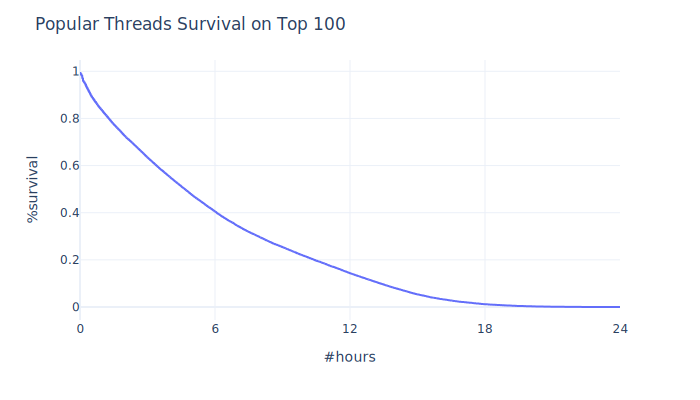

In [241]:
def display_all_survival(save=False):
    time, survival_probability = kme(
        np.ones(popular_threads.shape[0]).astype(bool),
        popular_threads['popular_window'] / 3_600
    )
    
    fig = px.line(x=time, y=survival_probability)
    
    fig.update_layout(
        template='plotly_white',
        showlegend=False,
        title=f'Popular Threads Survival on Top 100',
        height=400
    )
    
    fig.update_xaxes(title='#hours', range=[0, 24], tickvals=[0, 6, 12, 18, 24])
    fig.update_yaxes(title='%survival')
    
    if save:
        fig.write_image('figs/all_survival.png', scale=3)
    
    fig.show('svg')

display_all_survival(save=True)

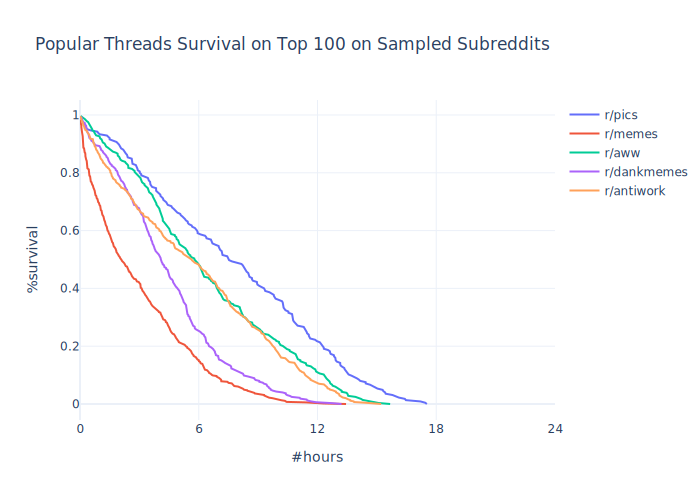

In [243]:
def display_subreddit_survival(save=False,
                                        subreddits=None,
                                        n=5,
                                        threshold=200,
                                        seed=None):

    fig = go.Figure()

    if subreddits is not None:
        sample_subreddits = subreddits
    else:
        sample_subreddits = popular_threads['subreddit'].value_counts()[popular_threads['subreddit'].value_counts() > 200] \

        if seed is None:
            sample_subreddits = sample_subreddits.sample(n=n).index
        else:
            sample_subreddits = sample_subreddits \
                .sample(n=n, random_state=seed).index

    for subreddit in sample_subreddits:

        threads = popular_threads[popular_threads['subreddit'] == subreddit]

        time, survival_probability = kme(
            np.ones(threads.shape[0]).astype(bool),
            threads['popular_window'] / 3_600
        )

        fig.add_trace(go.Scatter(
            x=time,
            y=survival_probability,
            name=f'r/{subreddit}'
        ))

    fig.update_layout(
        template='plotly_white',
        title=f'Popular Threads Survival on Top 100 on Sampled Subreddits',
        height=500,
        width=700
    )

    fig.update_xaxes(title='#hours', 
                     range=[0, 24], 
                     tickvals=[0, 6, 12, 18, 24])
    fig.update_yaxes(title='%survival')
    
    if save:
        fig.write_image('figs/subreddit_survival.png', scale=3)

    fig.show('svg')


display_subreddit_survival(save=True, n=5, seed=38)

In [314]:
def display_cox_survival_analysis():
    
    assert popular_threads is not None, 'Get r/popular threads.'
    
    data = popular_threads[popular_threads['subreddit'].isin(sample_subreddits)] \
        [['created_to_popular', 'popular_window', 'subreddit']] \
        .join(complete_comment_features.groupby('link_id')['removed'].sum()) \
        .join(complete_comment_features.groupby('link_id')['newcomer'].sum()) \
        .join(complete_comment_features.groupby('link_id')['subreddit'].count().rename('comments')) \
        .join(praw_features[['active_window', 'num_authors']]) \
        .join(subreddit_features, on='subreddit')
    
    print(f'Number of r/popular threads: {data.shape[0]}')
    unique_subreddits = len(data['subreddit'].unique())
    print(f'Number of subreddits: {unique_subreddits}')
    
    data['created_to_popular'] = data['created_to_popular'] / 3_600
    data['popular_window'] = data['popular_window'] / 3_600
    data['active_window'] = data['active_window'] / 3_600
    
    estimator = cox()
    
    x = data[['created_to_popular', 'removed', 'newcomer', 'comments', 'active_window',
              'num_authors', 'num_moderators', 'num_subscribers']]
    y = np.array([(True, value) for value in data['popular_window']],
            dtype=[('Status', '?'), ('Survival', '<f8')])
    
    estimator.fit(x, y)
    
    return pd.Series(estimator.coef_, index=x.columns) \
        .to_frame() \
        .rename(columns={0: 'Coefficient'})
    

display_cox_survival_analysis().round(6)
# Below is the log hazard ratio.

Number of r/popular threads: 5712
Number of subreddits: 100


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Tables

In [76]:
def describe_popular_threads(to_latex=False):
    
    assert popular_threads is not None, 'Get r/popular threads.'
    
    table = pd.DataFrame()
    
    table = table.append((popular_threads['created_to_popular'] / 3_600).describe())
    table = table.append((popular_threads['popular_window'] / 3_600).describe())
    
    table.index = ['Created to Popular (hours)', 'Popular Window (hours)']
    
    if praw_features is not None:
        table = table.append((praw_features['active_window'] / 3_600).describe())
        table.index = table.index.tolist()[:-1] + ['Active Window (hours)']
    
    table = table.rename(columns={
        'max': 'Max',
        'mean': 'Mean',
        'count': 'N',
        'min': 'Min',
        'std': 'SD'
    })
    
    table = table.round(2)
    
    columns = ['25%', '50%', '75%', 'Min', 'Mean', 'Max', 'SD', 'N']
    
    for column in columns:
        table[column] = table[column].apply(lambda x: f'{x:,}')
    
    table = table[columns].transpose()
    
    if to_latex:
        
        columns = table.columns
        
        table = table.to_latex(bold_rows=True, column_format='lrr')
        
        for rule in ['\\toprule', '\\midrule', '\\bottomrule']:
            table = table.replace(rule, '\hline')
            
        for column in columns:
            table = table.replace(column, f'\\textbf{{{column}}}')
            
        table = table[:table.rfind('\\textbf{N') - 1] + ' \hline' + table[table.rfind('\\textbf{N') - 1:]
        
        print(table)
    else:
        return table

describe_popular_threads(to_latex=False)

,Created to Popular (hours),Popular Window (hours),Active Window (hours)
25%,3.07,1.77,70.04
50%,4.36,4.66,161.86
75%,6.5,9.11,544.86
Min,0.17,0.0,3.67
Mean,5.44,6.17,348.31
Max,24.22,"1,588.53","1,650.27"
SD,3.55,19.17,387.96
N,"31,042.0","31,042.0",365.0
